# FOOOF Ratios + Trial by Trial variance analysis

This notebook explores the relationship between parameterized ratios and age.

In [33]:
import csv

import pandas as pd

import mne

# Import custom project code
import sys
sys.path.append('../bratios')
from ratios import *
from analysis import *
from settings import *
from plot import *

from paths import DATA_PATHS as dp

In [34]:
# Settings
SAVE_FIG = False
PROCESS_DATA = False   # If False, reload previously processed & saved data

In [35]:
N_BLOCKS = 5

In [36]:
# Set random seed
np.random.seed(53)

### Get data for all blocks (trials)

In [37]:
# Read datafile with dataset information
data = pd.read_csv(dp.make_file_path(dp.eeg_meta, 'MIPDB_PublicFile', 'csv'))

In [38]:
# Read in list of channel names that are kept in reduced 111 montage
with open(dp.make_file_path(dp.eeg_meta, 'chans111', 'csv'), 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# # Read montage, reduced to 111 channel selection
# montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

In [39]:
# Get the list of all channels
#all_chans = mne.pick_channels(, [])

all_chans = np.arange(0, len(ch_labels))

In [41]:
# Get the dataframes of the measures, per block
dfs = []
if PROCESS_DATA:
    
    for ind in range(0, N_BLOCKS):
        df = get_all_data(data, all_chans, ind, verbose=True)
        dfs.append(df)   
    
    # Save out dataframes
    for ind, df in enumerate(dfs):
        file_name = dp.make_file_path(\
            dp.eeg_outputs, 'block_{}_measures'.format(ind+1), 'csv')
        df.to_csv(file_name, index=False)

else:
    # Reload the dataframes
    for ind in range(N_BLOCKS):
        dfs.append(pd.read_csv(dp.make_file_path(\
            dp.eeg_outputs, 'block_{}_measures'.format(ind+1), 'csv')))

## Fooof ratio correlation with age

In [44]:
def fooof_ratio_corr(dfs, ratio_type, corr_func):
    """ Finds the correlation between fooof ratio and age
        Where fooof ratio := power at center frequency of most salient oscillation
        of high band / power at center frequency of most salient oscillation
        of low band.
    
    Parameters
    ----------
    dfs : list of dataframes
    ratio_type : sting
        Which bands to use in calculating fooof ratio
    corr_func:
        Function to calculate correlation
        
    Return
    ------
    Mean of correlations.
    """
    
    corrs =np.zeros(len(dfs))
    for ind, curr_df in enumerate(dfs):
    
        ratio_type = ratio_type.upper()

        numer = get_wave_params(ratio_type[0])[1]
        denom = get_wave_params(ratio_type[1])[1]

        fooof_ratios = curr_df[numer] / curr_df[denom]

        curr_corr = corr_func(curr_df["Age"], fooof_ratios)[0]

        corrs[ind] = curr_corr

        return np.mean(corrs)

In [45]:
fooof_ratio_corr(dfs, "tbr", nan_corr_spearman)

-0.025546951001306696

In [46]:
fooof_ratio_corr(dfs, "abr", nan_corr_spearman)

-0.009318713860579392

In [47]:
fooof_ratio_corr(dfs, "tar", nan_corr_spearman)

-0.019613274152317207

In [48]:
# for df in dfs:
#     print(len(df))

# Trial by Trial Basis

This section explores the relationship between band ratios and the aperidic exponent across trials.

In [49]:
def get_ratio_ap_var(dfs, ratio_type, corr_func):
    """Describes the stability of correlation between ratio measures and aperiodic exponent.
        
    Parameters
    ----------
    dfs : list of dataframes
    ratio_type : sting
        Which bands to use in calculating fooof ratio
    corr_func:
        Function to calculate correlation

    Outputs
    ------
    Variance of correlations.
    """
    
    corrs = []
    for curr_df in dfs:
        curr_corr = corr_func(curr_df["Exp"], curr_df[ratio_type])
        if curr_corr[1] < .05:
            corrs.append(curr_corr[0])
            
    print("variance: ", np.var(corrs))
    
    plt.title(ratio_type)
    plt.xlabel("trial")
    plt.ylabel("corr")
    plt.plot(corrs)

variance:  0.0006259790781878302


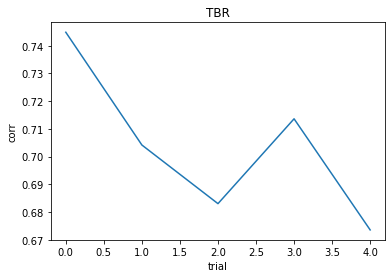

In [50]:
get_ratio_ap_var(dfs, "TBR", nan_corr_spearman)

variance:  0.0016460708058982036


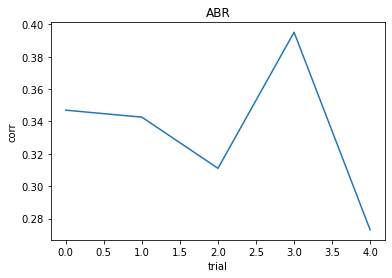

In [51]:
get_ratio_ap_var(dfs, "ABR", nan_corr_spearman)

variance:  0.0003083257392746945


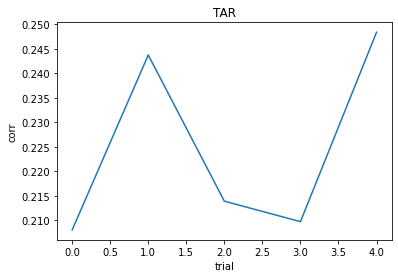

In [52]:
get_ratio_ap_var(dfs, "TAR", nan_corr_spearman)

In [53]:
avg_dfs = []
for df in dfs:
    avg_dfs.append(average_df(df, all_chans))

In [55]:
avg_dfs[0]

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,TAR,TBR,Theta_BW,Theta_CF,Theta_PW,fit_error,fit_n_peaks,fit_r2
Subj_ID,,,,,,,,,,,,,,,,,,,
A00051826,8.532228,10.0,2.317085,10.374870,0.655958,1.557177,19.883751,0.276152,55.0,1.879970,1.483178,2.471751,20.574601,1.826479,7.011446,0.674259,0.070306,5.612613,0.983773
A00051886,12.476537,12.0,1.658957,9.823657,1.263577,3.530663,16.922691,0.619895,55.0,1.905764,0.919439,0.524417,5.698411,1.028187,5.143273,0.225602,0.070946,6.027027,0.984375
A00051955,8.891571,12.0,1.665214,9.055067,1.144416,3.747022,14.189513,0.577361,55.0,1.805246,1.453675,0.870552,7.420622,1.630119,6.768538,0.445138,0.065727,6.495495,0.985089
A00053375,9.217853,6.0,1.828574,9.711305,0.755370,1.593055,24.766122,0.239572,55.0,1.784511,1.532283,1.227735,10.686748,2.630019,5.885581,0.177479,0.066909,6.018018,0.977576
A00053398,7.521744,12.0,2.377545,9.920910,0.862770,1.944976,21.962618,0.461678,55.0,1.587955,1.365993,0.883476,6.297080,1.518985,7.134986,0.396997,0.069286,5.990991,0.975398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00063029,20.889638,40.0,1.583647,9.453139,1.679347,2.074980,19.486836,0.617590,55.0,1.371126,0.339545,0.235673,3.975082,1.355135,7.192561,0.476401,0.079621,6.099099,0.972264
A00063051,19.658474,23.0,1.693768,10.823757,1.628555,2.251945,20.037320,0.581907,55.0,1.668285,0.746468,0.301625,5.553629,1.138758,6.620409,0.486010,0.073865,5.855856,0.981892
A00063117,2.869250,24.0,1.957233,11.513328,0.326821,1.332589,26.057210,0.304173,55.0,1.436610,-0.042141,2.415752,6.556926,1.970824,4.969896,0.228188,0.067637,6.603604,0.957318


In [78]:
subjs = list(avg_dfs[-1].index)

In [87]:
n_subjs = len(subjs)

In [75]:
#subj = 'A00051826'
subj = 'A00053480'

tbrs = []
exps = []
for df in avg_dfs:
    
    tbrs.append(df.loc[subj].TBR)
    exps.append(df.loc[subj].Exp)

corr_func(tbrs, exps)

SpearmanrResult(correlation=0.7, pvalue=0.1881204043741873)

In [152]:

corrs = []
for subj in subjs:
    tbrs = []
    exps = []
    for df in avg_dfs:

        tbrs.append(df.loc[subj].TBR)
        exps.append(df.loc[subj].Exp)

    corrs.append(corr_func(tbrs, exps)[0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a252d53d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a252d5210>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a252d54d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a252d5550>}

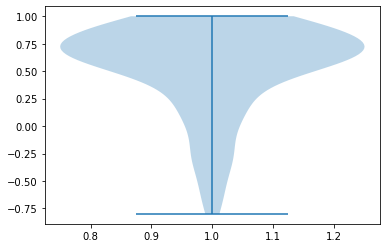

In [153]:
plt.violinplot(corrs)

In [154]:
exps = np.zeros([n_subjs, N_BLOCKS])
brs = np.zeros([n_subjs, N_BLOCKS])

for s_ind, subj in enumerate(subjs):
    for bl_ind, df in enumerate(avg_dfs):

        brs[s_ind, bl_ind] = df.loc[subj].TBR
        exps[s_ind, bl_ind] = df.loc[subj].Exp

In [155]:
brs_sort_inds = np.zeros([n_subjs, N_BLOCKS], dtype=int)
exp_sort_inds = np.zeros([n_subjs, N_BLOCKS], dtype=int)
for s_ind in range(n_subjs):
    brs_sort_inds[s_ind, :] = np.argsort(brs[s_ind])
    exp_sort_inds[s_ind, :] = np.argsort(exps[s_ind])

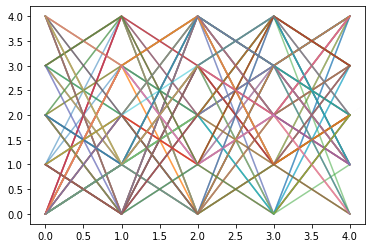

In [156]:
for s_ind, sort in enumerate(exp_sort_inds):
    plt.plot(brs_sort_inds[s_ind, sort], alpha=0.5)

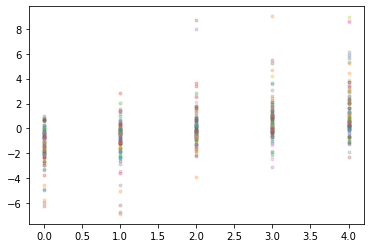

In [175]:
for s_ind, sort in enumerate(exp_sort_inds):
    data = brs[s_ind, sort]
    plt.plot(data - np.mean(data), '.', alpha=0.25)

In [176]:
data

array([6.60320022, 6.17990376, 5.8491749 , 6.75409287, 7.36254818])

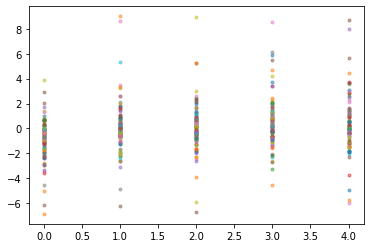

In [166]:
for s_ind, data in enumerate(brs):
    plt.plot(data - np.mean(data), '.', alpha=0.5)

In [161]:
brs[0, exp_sort_inds[0, ]]

array([14.97506967, 20.57460083, 21.43994304, 21.71583875, 20.98786168])

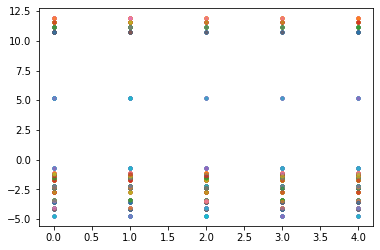

In [174]:
for data in brs[exp_sort_inds]:
    plt.plot(data - np.mean(data), '.', alpha=0.5)

In [178]:
brs[][-1, :]

array([[20.57460083, 21.71583875, 20.98786168, 21.43994304, 14.97506967],
       [ 5.69841091,  5.76937049,  6.4508547 ,  8.60594932,  5.08771053],
       [ 8.60016655,  8.66076874,  8.23538971,  8.40832829,  9.15915899],
       [ 7.42062249,  6.33620831,  7.42971713,  7.09836847,  5.76008646],
       [ 6.29708019,  7.5250241 ,  7.56638127,  8.07380829,  7.56526719]])

In [183]:
qq = brs[list(exp_sort_inds)]

In [188]:
sorted_brs = brs.copy()
for ind in range(n_subjs):
    sorted_brs[ind, :] = sorted_brs[ind, exp_sort_inds[ind, :]]

(-4.0, 4.0)

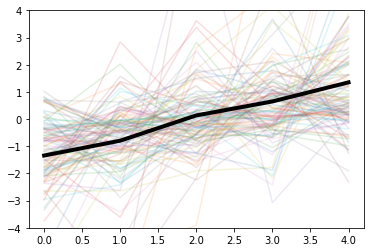

In [206]:
for row in sorted_brs:
    plt.plot(row - np.mean(row), alpha=0.15)
    
avg = np.mean(sorted_brs, 0)
plt.plot(avg - np.mean(avg), 'k', lw=4)
plt.ylim([-4, 4])

In [207]:
rr = avg - np.median(avg)
rr

array([-1.47580546, -0.92937487,  0.        ,  0.51426824,  1.21604892])

In [208]:
corr_func(range(0, 5), rr)

SpearmanrResult(correlation=0.9999999999999999, pvalue=1.4042654220543672e-24)